# Immune Atlas DA Peaks

**Created**: 19 March 2022

In [1]:
if (!requireNamespace("BiocManager", quietly=TRUE)) {
    install.packages("BiocManager")
}

if (!requireNamespace("limma", quietly=TRUE)) {
    BiocManager::install("limma")
}

if (!requireNamespace("edgeR", quietly=TRUE)) {
    BiocManager::install("edgeR")
}

if (!requireNamespace("UpSetR", quietly=TRUE)) {
    install.packages("UpSetR")
}

if (!requireNamespace("umap")) {
    install.packages("umap")
}

if (!requireNamespace("patchwork")) {
    install.packages("devtools")
    devtools::install_github("thomasp85/patchwork")
}

Loading required namespace: umap

Loading required namespace: patchwork



In [2]:
library(tidyverse)
library(RColorBrewer)
library(data.table)
library(edgeR)
library(limma)
library(umap)
library(UpSetR)
library(parallel)
library(patchwork)

setwd("~/eQTL_pQTL_Characterization/")

source("03_Functional_Interpretation/scripts/utils/ggplot_theme.R")

── Attaching packages ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.6     ✔ dplyr   1.0.7
✔ tidyr   1.1.4     ✔ stringr 1.4.0
✔ readr   2.1.1     ✔ forcats 0.5.1

── Conflicts ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘data.table’


The following objects are masked from ‘package:dplyr’:

    between, first, last


The following object is masked from ‘package:purrr’:

    transpose


Loading required package: limma



## Load Data

In [3]:
sample.info <- read.csv("03_Functional_Interpretation/metadata/reads_atac_seq.txt")

sample.info <- sample.info %>%
    dplyr::select(Group.ID, Donor, Lineage, Cell_type, Stimulated, Treatment) %>%
    dplyr::filter(grepl("(Corces|Calderon)", Donor)) %>%
    unique() %>%
    dplyr::mutate(Treatment = gsub("Treatment_(1|2)", "Stimulated", Treatment)) %>%
    dplyr::mutate(Donor = gsub("-", "", Donor)) %>%
    dplyr::arrange(Lineage, Cell_type, Treatment, Donor)

rownames(sample.info) <- sample.info$Group.ID

In [4]:
head(sample.info)

,Group.ID,Donor,Lineage,Cell_type,Stimulated,Treatment
,<chr>,<chr>,<chr>,<chr>,<lgl>,<chr>
Calderon-1001-Bulk_B-Control,Calderon-1001-Bulk_B-Control,Calderon1001,B,Bulk_B,FALSE,Control
Calderon-1002-Bulk_B-Control,Calderon-1002-Bulk_B-Control,Calderon1002,B,Bulk_B,FALSE,Control
Calderon-1003-Bulk_B-Control,Calderon-1003-Bulk_B-Control,Calderon1003,B,Bulk_B,FALSE,Control
Calderon-1004-Bulk_B-Control,Calderon-1004-Bulk_B-Control,Calderon1004,B,Bulk_B,FALSE,Control
Calderon-1001-Bulk_B-Treatment_1,Calderon-1001-Bulk_B-Treatment_1,Calderon1001,B,Bulk_B,TRUE,Stimulated
Calderon-1002-Bulk_B-Treatment_1,Calderon-1002-Bulk_B-Treatment_1,Calderon1002,B,Bulk_B,TRUE,Stimulated


In [5]:
peak.counts <- fread("~/gains_team282/epigenetics/accessibility/analysis/atac_seq/immune/peak_counts.tsv", header=T)

colnames(peak.counts) <- sapply(strsplit(colnames(peak.counts), "\\."), function(x) { x[1] })

peak.counts <- peak.counts %>%
    dplyr::select(GeneID, Chr, Start, End, Strand, all_of(sample.info$Group.ID))

In [6]:
head(peak.counts)

GeneID,Chr,Start,End,Strand,Calderon-1001-Bulk_B-Control,Calderon-1002-Bulk_B-Control,Calderon-1003-Bulk_B-Control,Calderon-1004-Bulk_B-Control,Calderon-1001-Bulk_B-Treatment_1,⋯,Calderon-1003-Mature_NK-Treatment_1,Calderon-1004-Mature_NK-Treatment_1,Calderon-1008-Mature_NK-Treatment_2,Calderon-1010-Mature_NK-Treatment_2,Calderon-1001-Memory_NK-Control,Calderon-1002-Memory_NK-Control,Calderon-1003-Memory_NK-Control,Calderon-1004-Memory_NK-Control,Calderon-1008-Memory_NK-Control,Calderon-1010-Memory_NK-Control
<chr>,<chr>,<int>,<int>,<chr>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1:23224-23849,1,23224,23849,+,30,44,13,21,60,⋯,11,55,37,38,29,76,4,8,56,36
1:24025-26778,1,24025,26778,+,133,179,70,175,153,⋯,63,296,218,204,93,275,26,83,261,211
1:28524-30136,1,28524,30136,+,1529,220,286,380,1820,⋯,464,610,635,444,2745,200,64,1338,768,318
1:30354-30875,1,30354,30875,+,21,22,8,14,32,⋯,8,43,42,23,13,35,0,4,38,51
1:31109-31894,1,31109,31894,+,39,47,30,45,36,⋯,32,50,87,47,44,59,6,46,94,48
1:32151-32330,1,32151,32330,+,13,7,10,12,9,⋯,8,27,29,15,8,16,0,8,17,20


In [7]:
tss.enrichment <- read.table("~/gains_team282/epigenetics/accessibility/analysis/atac_seq/tss_enrichment_scores.tsv", header=T)

rownames(tss.enrichment) <- tss.enrichment$Sample

tss.enrichment <- tss.enrichment[sample.info$Group.ID, ]

In [8]:
head(tss.enrichment)

,Sample,TSS_Enrichment_Score
,<chr>,<dbl>
Calderon-1001-Bulk_B-Control,Calderon-1001-Bulk_B-Control,24.193262
Calderon-1002-Bulk_B-Control,Calderon-1002-Bulk_B-Control,4.758203
Calderon-1003-Bulk_B-Control,Calderon-1003-Bulk_B-Control,18.408903
Calderon-1004-Bulk_B-Control,Calderon-1004-Bulk_B-Control,9.635612
Calderon-1001-Bulk_B-Treatment_1,Calderon-1001-Bulk_B-Treatment_1,25.348657
Calderon-1002-Bulk_B-Treatment_1,Calderon-1002-Bulk_B-Treatment_1,16.749014


## Limma-Voom Modeling

### Count Matrix

Set up the count matrix in the format required for Limma.

In [9]:
count.mtx <- as.matrix(peak.counts[,-(1:5)])
rownames(count.mtx) <- peak.counts$GeneID

### Create Sample Groups for Immune Atlas

Biological groups will be defined by specific stimulation condition. The stimulation condition have a higher resolution in this study (multiple treatments across donors).

In [10]:
cell.type <- factor(sample.info$Cell_type)
stimulated <- factor(sample.info$Treatment)
groups <- interaction(cell.type, stimulated, sep="_")
groups <- droplevels(groups)

Batch effects that I will correct for include donor and TSS Enrichment Score.

In [11]:
donors <- factor(sample.info$Donor)
donors <- droplevels(donors)
tss.score <- as.matrix(tss.enrichment$TSS_Enrichment_Score)

Design matrix for the neutrophil atlas.

In [12]:
design <- model.matrix(~0 + groups + donors + tss.score)

### Create DGEList

`edgeR` can be used to handle count matrices. We will use `voom` in the next step to process this `edgeR` object.

In [13]:
dge <- DGEList(count.mtx)

Filter peaks using in-build `edgeR` function.

In [14]:
keep <- filterByExpr(dge, design=design, min.count=50, min.prop=0.5)
dge <- dge[keep, , keep.lib.sizes=FALSE]

In [15]:
dim(dge)

[1] 656324    178

Calculate normalization factors for the trimmed mean of M-values method.

In [16]:
dge <- calcNormFactors(dge, method="TMM")

### Voom for Neutrophil Atlas

`voom` models a count matrix by empirically identifying the mean-variance relationship within the data. The count matrix can then be normalized and batch effects can be removed. The normalized data can be used in downstream analysis with `limma`.

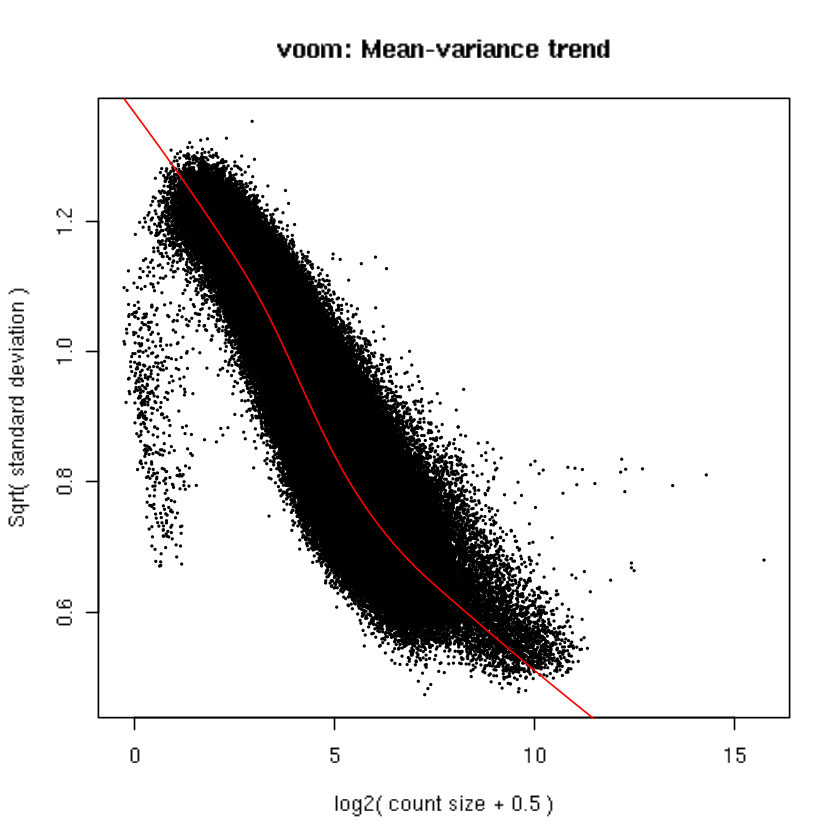

In [17]:
y <- voom(dge, design, plot=TRUE)

### Visualize Normalized Counts

In [18]:
pca <- prcomp(t(as.matrix(y)))

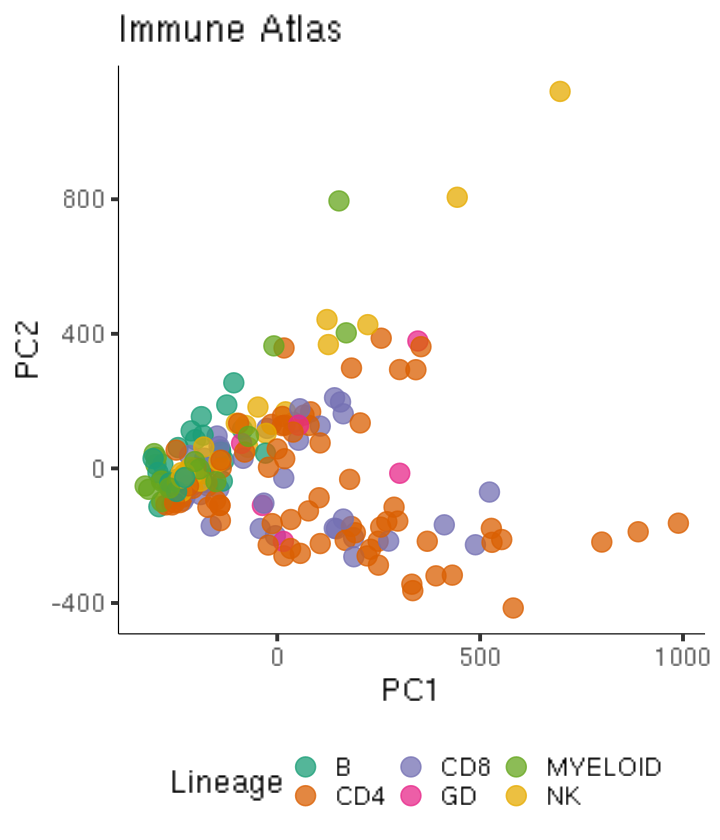

In [19]:
options(repr.plot.width=6, repr.plot.height=7)

merge(pca$x, sample.info, by.x=0, by.y="Group.ID") %>%
    as.data.frame() %>%
    ggplot() +
    geom_point(aes(x=PC1, y=PC2, color=Lineage), size=I(5), alpha=0.75) +
    scale_color_brewer(palette="Dark2") +
    labs(color="Lineage") +
    ggtitle("Immune Atlas") +
    ggplot_theme

ggsave("03_Functional_Interpretation/results/immune_normalized_peak_count_pca.svg", width=6, height=7)

In [20]:
umap.res <- umap(scale(t(as.matrix(y))))

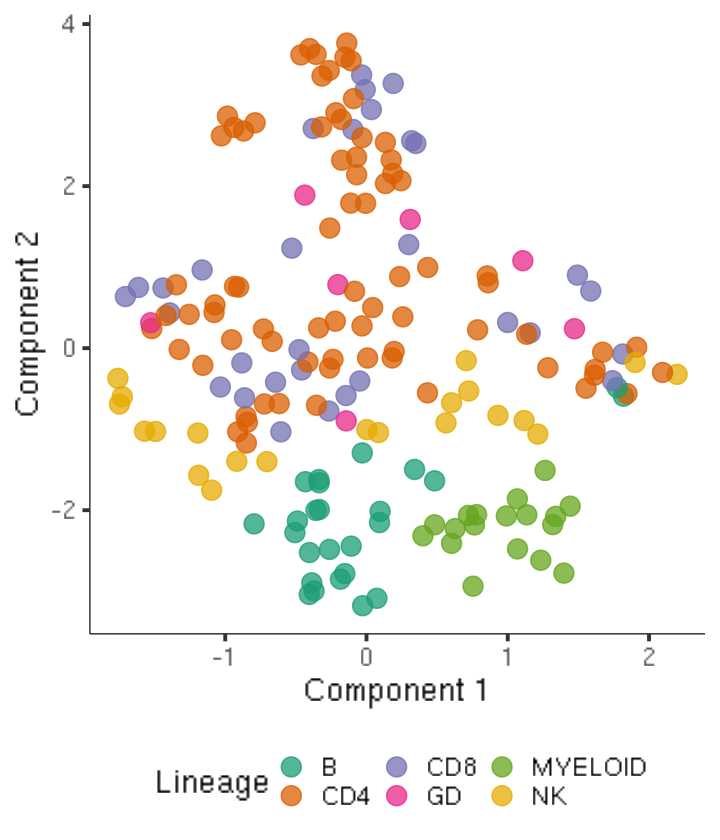

In [21]:
options(repr.plot.width=6, repr.plot.height=7)

umap.res$layout %>%
    as.data.frame() %>%
    dplyr::select(Comp1=1, Comp2=2) %>%
    dplyr::mutate(Group.ID=rownames(.)) %>%
    merge(., sample.info, by="Group.ID") %>%
    ggplot() +
    geom_point(aes(x=Comp1, y=Comp2, color=Lineage), size=I(5), alpha=0.75) +
    scale_color_brewer(palette="Dark2") +
    xlab("Component 1") + ylab("Component 2") +
    ggplot_theme

### Limma Fit

Use `limma` to fit a linear model consisting of the biological `groups`.

In [22]:
fit <- lmFit(y, design)

### Limma DA Peaks

Identify all cell types where both the baseline and stimulated conditions are present.

In [23]:
cell.type.conditions <- sample.info %>%
    dplyr::filter(grepl("(Corces|Calderon)", Group.ID)) %>%
    dplyr::select(Cell.Type=Cell_type, Treatment) %>%
    dplyr::group_by(Cell.Type, Treatment) %>%
    dplyr::summarize(N=n(), .groups="drop") %>%
    tidyr::spread(Treatment, N) %>%
    na.omit()

Create contrasts for each cell type that has both baseline and stimulated conditions.

In [24]:
contrast <- matrix(0, nrow=ncol(coef(fit)), ncol=nrow(cell.type.conditions))
rownames(contrast) <- colnames(coef(fit))
colnames(contrast) <- paste0(cell.type.conditions$Cell.Type, "_Stimulated-", cell.type.conditions$Cell.Type, "_Control")

for (i in 1:nrow(cell.type.conditions)) {
    cell.type.condition = cell.type.conditions$Cell.Type[i]
    contrast[paste0("groups", cell.type.condition, "_Stimulated"), i] = 1
    contrast[paste0("groups", cell.type.condition, "_Control"), i] = -1
}

In [25]:
da.peaks <- rbindlist(lapply(1:ncol(contrast), function(i) {
    de.res = eBayes(contrasts.fit(fit, contrast[,i]))
    de.res.table = topTable(de.res, sort.by="p", n=Inf)
    
    contrast.cell.type = strsplit(colnames(contrast)[i], "-")[[1]][1]
    contrast.cell.type = substr(contrast.cell.type, start=1, stop=nchar(contrast.cell.type) - 11)

    de.res.table %>%
        dplyr::mutate(Contrast=colnames(contrast)[i]) %>%
        dplyr::mutate(Cell.Type=contrast.cell.type) %>%
        dplyr::mutate(Peak.ID=rownames(.)) %>%
        dplyr::mutate(Peak.Chr=sapply(strsplit(Peak.ID, ":"), function(x) { x[1] })) %>%
        dplyr::mutate(Peak.Coords=sapply(strsplit(Peak.ID, ":"), function(x) { x[2] })) %>%
        dplyr::mutate(Peak.Start=sapply(strsplit(Peak.Coords, "-"), function(x) { x[1] })) %>%
        dplyr::mutate(Peak.End=sapply(strsplit(Peak.Coords, "-"), function(x) { x[2] })) %>%
        dplyr::select(Contrast, Cell.Type, Peak.ID, Peak.Chr, Peak.Start, Peak.End, logFC, AveExpr, t, P.Value, adj.P.Val, B)
}))

## Differentially Accessible Peaks

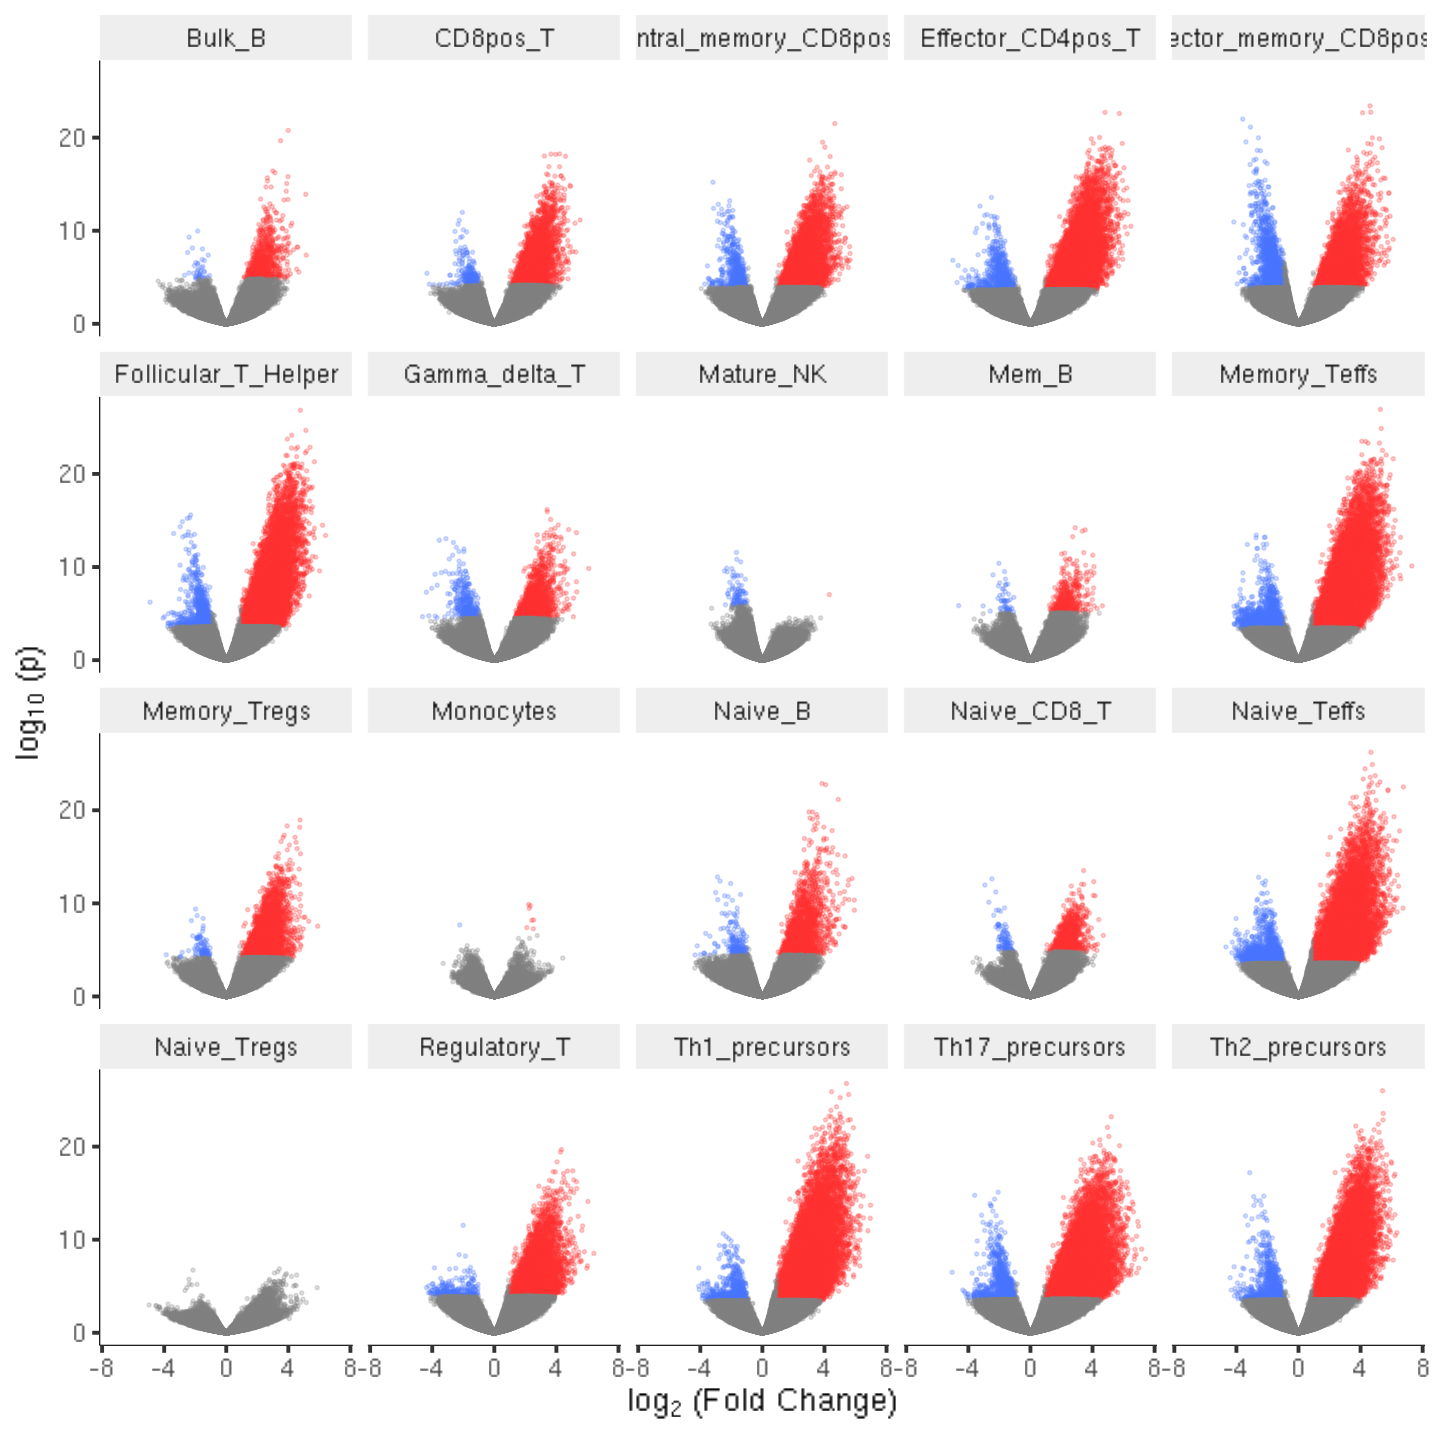

In [26]:
options(repr.plot.width=12, repr.plot.height=12)

abs.max.log.fc <- max(abs(da.peaks$logFC))

da.peaks %>%
    dplyr::mutate(log.P.Val=-log10(P.Value)) %>%
    dplyr::mutate(Accessible=ifelse(adj.P.Val < 0.01 & logFC > 1, "More", ifelse(adj.P.Val < 0.01 & logFC < -1, "Less", "Same"))) %>%
    ggplot() +
    geom_point(aes(x=logFC, y=log.P.Val, color=Accessible), size=I(0.5), alpha=0.25) +
    scale_color_manual(values=c("More"="firebrick1", "Less"="royalblue1")) +
    guides(color="none") +
    facet_wrap(vars(Cell.Type)) +
    xlim(-abs.max.log.fc, abs.max.log.fc) +
    xlab(bquote("log"[2]~"(Fold Change)")) + ylab(bquote("log"[10]~"(p)")) +
    ggplot_theme

ggsave("03_Functional_Interpretation/results/immune_da_peaks_volcano_plots.png", width=12, height=12)

Calculate differentially accessible peaks. For each contrast, a peak is considered differentially accessible if the adjusted P-value is < 0.01 and the absolute log fold change is greater than 1.

In [35]:
da.peak.set <- da.peaks %>%
    dplyr::filter(adj.P.Val < 0.01) %>%
    dplyr::filter(abs(logFC) > 1)

write.csv(da.peak.set, "~/gains_team282/epigenetics/accessibility/analysis/atac_seq/immune/da_peak_set.csv")

There are 45921 peaks that are DA peaks in at least one treatment.

In [36]:
length(unique(da.peak.set$Peak.ID))

[1] 45921

In [37]:
table(da.peak.set$Contrast)


                                    Bulk_B_Stimulated-Bulk_B_Control 
                                                                 986 
                                CD8pos_T_Stimulated-CD8pos_T_Control 
                                                                4795 
  Central_memory_CD8pos_T_Stimulated-Central_memory_CD8pos_T_Control 
                                                                8201 
              Effector_CD4pos_T_Stimulated-Effector_CD4pos_T_Control 
                                                               13914 
Effector_memory_CD8pos_T_Stimulated-Effector_memory_CD8pos_T_Control 
                                                                8109 
          Follicular_T_Helper_Stimulated-Follicular_T_Helper_Control 
                                                               16342 
                      Gamma_delta_T_Stimulated-Gamma_delta_T_Control 
                                                                2052 
                   